In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train[0].shape

(28, 28)

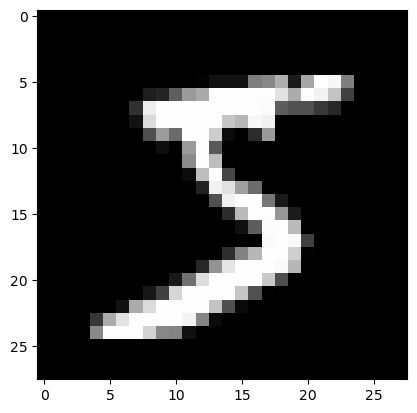

In [4]:
plt.imshow(X_train[0], cmap='gray')

In [5]:
y_train[0]

5

In [6]:
pd.Series(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [7]:
import torch.nn as nn

class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        #If RGB feature maps, in_channels=3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        #If binary classification, last layer outputs 2 values
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        #If binary classification, last layer uses nn.functional.sigmoid
        return x

In [8]:
from skorch.classifier import NeuralNetClassifier
import torch

model = NeuralNetClassifier(module=CNNModel, device='cuda' if torch.cuda.is_available() else 'cpu')
#If binary classification, nn_model uses NeuralNetBinaryClassifier 

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [11]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [12]:
X_train[0].shape

torch.Size([1, 28, 28])

In [13]:
model.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3002       0.1123        2.2972  56.9583
      2        2.2472       0.6813        1.6338  56.8247
      3        0.8627       0.8711        0.4145  56.9320
      4        0.4698       0.9133        0.2750  56.9802
      5        0.3391       0.9397        0.1963  56.7840
      6        0.2641       0.9553        0.1508  57.1264
      7        0.2158       0.9614        0.1275  56.3585
      8        0.1873       0.9646        0.1173  55.8821
      9        0.1665       0.9680        0.1066  56.3728
     10        0.1496       0.9709        0.0955  56.4949


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNNModel(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.25, inplace=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.25, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3136, out_features=256, bias=True)
    (dropout3): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  ),
)

In [14]:
y_test_pred = model.predict(X_test)
y_test_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.95      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [16]:
confusion_matrix(y_test,y_test_pred)

array([[ 972,    0,    0,    0,    0,    0,    2,    1,    5,    0],
       [   0, 1128,    4,    0,    0,    0,    1,    0,    2,    0],
       [   7,    2, 1000,    7,    0,    0,    0,    5,   11,    0],
       [   0,    2,    6,  964,    0,   14,    0,    8,   11,    5],
       [   0,    0,    2,    0,  964,    0,    4,    1,    1,   10],
       [   2,    0,    1,    4,    2,  872,    3,    1,    4,    3],
       [   9,    3,    0,    0,    3,    5,  936,    0,    2,    0],
       [   2,    6,   13,    1,    3,    0,    0,  980,    5,   18],
       [   5,    0,    3,    3,    3,    6,    0,    3,  948,    3],
       [   4,    7,    0,    6,   17,    3,    0,    4,    7,  961]],
      dtype=int64)

In [17]:
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_proba

array([[2.08754454e-08, 2.37868059e-09, 2.78418247e-06, ...,
        9.99950528e-01, 1.24772987e-06, 1.63391451e-05],
       [3.03364125e-08, 3.44266795e-04, 9.99650836e-01, ...,
        3.08757075e-10, 1.83278996e-06, 1.17720005e-12],
       [1.52938719e-05, 9.99192774e-01, 7.00261007e-05, ...,
        5.24308707e-05, 3.71826551e-04, 2.30731148e-05],
       ...,
       [2.66211150e-11, 1.26650090e-09, 1.66052505e-09, ...,
        2.43599220e-06, 6.16457419e-06, 1.66909408e-03],
       [1.59251977e-06, 1.16240372e-07, 1.01856825e-08, ...,
        7.79509524e-09, 1.91768017e-02, 6.60800659e-09],
       [6.04730849e-06, 3.70789545e-11, 3.58922648e-07, ...,
        4.37910298e-12, 6.58058781e-08, 7.47380435e-10]], dtype=float32)

Text(0.5, 1.0, 'Receiver Operating Characteristic - CNNClassifier (Tensorflow)')

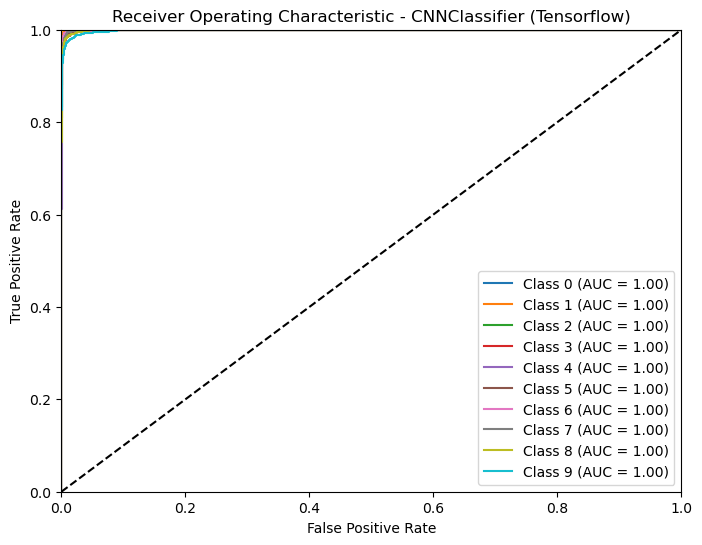

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
for class_idx in range(len(model.classes_)):
    y_true = (y_test == model.classes_[class_idx]).astype(int)
    y_pred_proba = y_test_pred_proba[:, class_idx]
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'Class {model.classes_[class_idx]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CNNClassifier (Tensorflow)')